In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime as dt
import random
import itertools
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

def agg_monthly_value(df, col='Value', agg_method='sum'):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=['Date']).dropna()
    df = df.set_index('Date')
    if agg_method  == 'sum' or agg_method is None:
        data = df.groupby(['Date'])[col].sum()
    elif agg_method == 'avg':
        data = df.groupby(['Date'])[col].mean()
    else:
        data = df.groupby(['Date'])[col].sum()
    return data

df = pd.read_csv("../data/processed/processed.csv", index_col=0)
df.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Location,location_x,location_y,year,month,agg_month,avg_temperature,GDP,is_anomaly
0,Calexico East,California,2507,US-Mexico Border,2019/3/1,Trucks,34447,POINT (-115.48433000000001 32.67524),-115.48433,32.67524,2019,3,279,48.8,3087669.4,0
1,Van Buren,Maine,108,US-Canada Border,2019/3/1,Rail Containers Full,428,POINT (-67.94271 47.16207),-67.94271,47.16207,2019,3,279,24.6,66589.8,0
2,Otay Mesa,California,2506,US-Mexico Border,2019/3/1,Trucks,81217,POINT (-117.05333 32.57333),-117.05333,32.57333,2019,3,279,48.8,3087669.4,0
3,Nogales,Arizona,2604,US-Mexico Border,2019/3/1,Trains,62,POINT (-110.93361 31.340279999999996),-110.93361,31.34028,2019,3,279,51.7,359404.7,0
4,Trout River,New York,715,US-Canada Border,2019/3/1,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005),-73.44253,44.99001,2019,3,279,29.5,1707519.5,0


Try decomposition on various subsets. Constructing subsets.

In [8]:
df_trucks = df[(df['Measure'] == 'Trucks')]
df_CA = df[(df['State'] == 'California')]
df_alaska = df[(df['State'] == 'Alaska')]
df_texas = df[(df['State'] == 'Texas')]
df_us_ca = df[(df['Border'] == 'US-Canada Border')]
df_us_mx = df[(df['Border'] == 'US-Mexico Border')]

def get_subset(state):
    return df[(df['State'] == state)]

def log_df(df):
    data_agg = agg_monthly_value(df)
    df_log_r = np.log(data_agg)
    df_log_r.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_log_r.dropna(how="all", inplace=True)
    return df_log_r

<Figure size 1200x500 with 0 Axes>

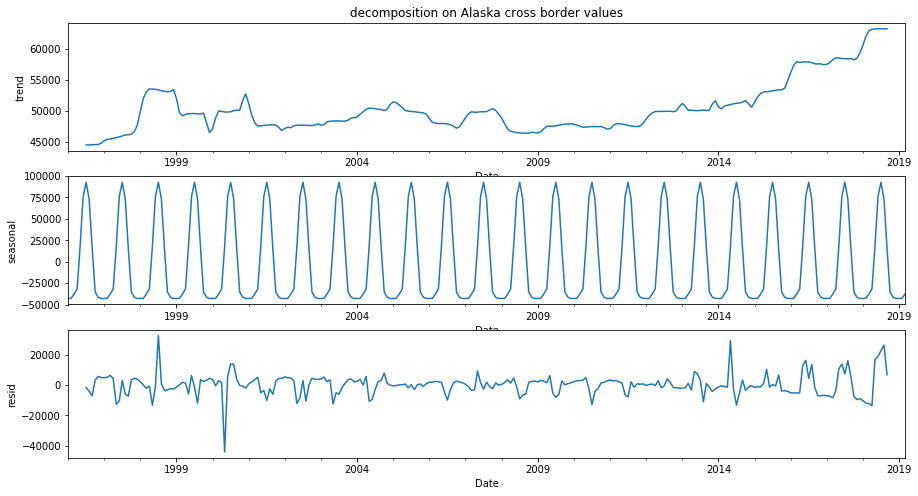

<Figure size 1200x500 with 0 Axes>

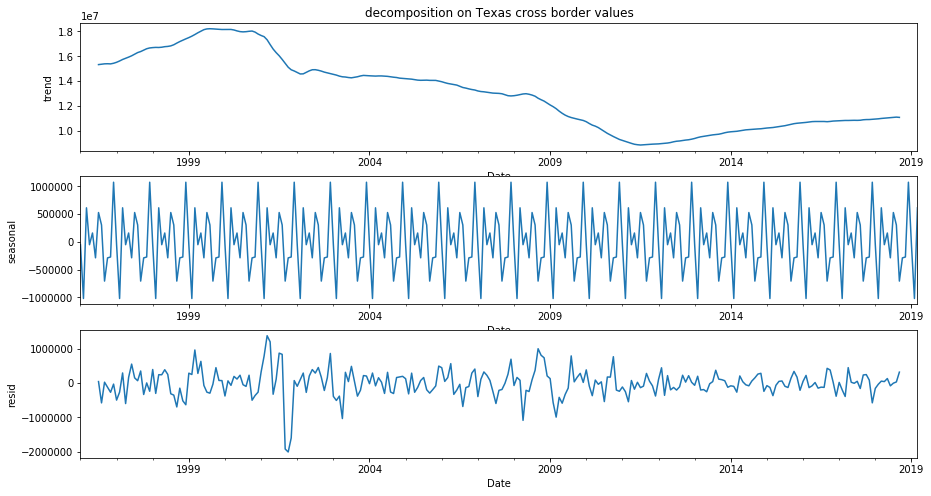

In [5]:
def decompose_df(df, title, need_agg=False):
    if need_agg is True:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by=['Date']).dropna()
        df = df.set_index('Date')
        df = df.groupby(['Date']).Value.sum()
    plt.figure(figsize=(12, 5), dpi=100)
    decomposed = seasonal_decompose(df, model='additive')
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
    decomposed.trend.plot(ax=ax1)
    ax1.set_ylabel('trend')
    ax1.set_title("decomposition on {} cross border values".format(title))
    decomposed.seasonal.plot(ax=ax2)
    ax2.set_ylabel('seasonal')
    decomposed.resid.plot(ax=ax3)
    ax3.set_ylabel('resid')
    plt.show()
    
data_alaska = agg_monthly_value(df_alaska)
decompose_df(data_alaska, 'Alaska')

data_texas = agg_monthly_value(df_texas)
decompose_df(data_texas, 'Texas')

<Figure size 1200x500 with 0 Axes>

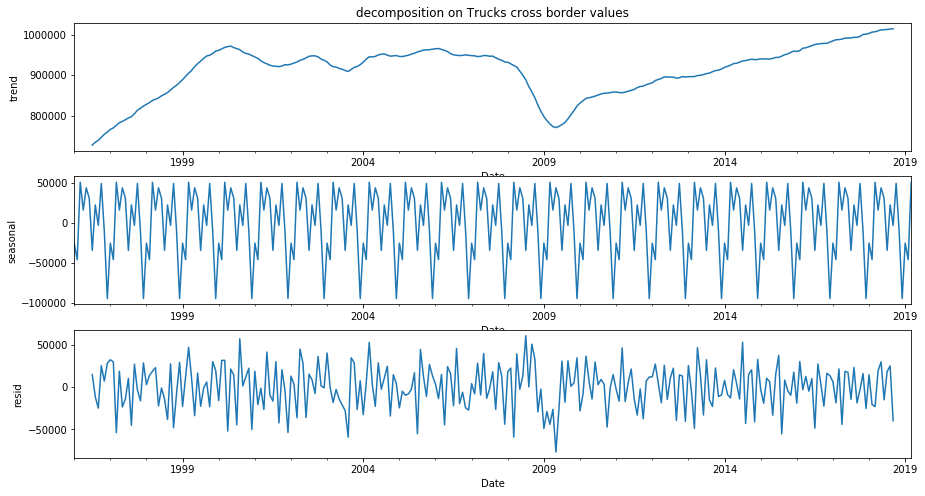

<Figure size 1200x500 with 0 Axes>

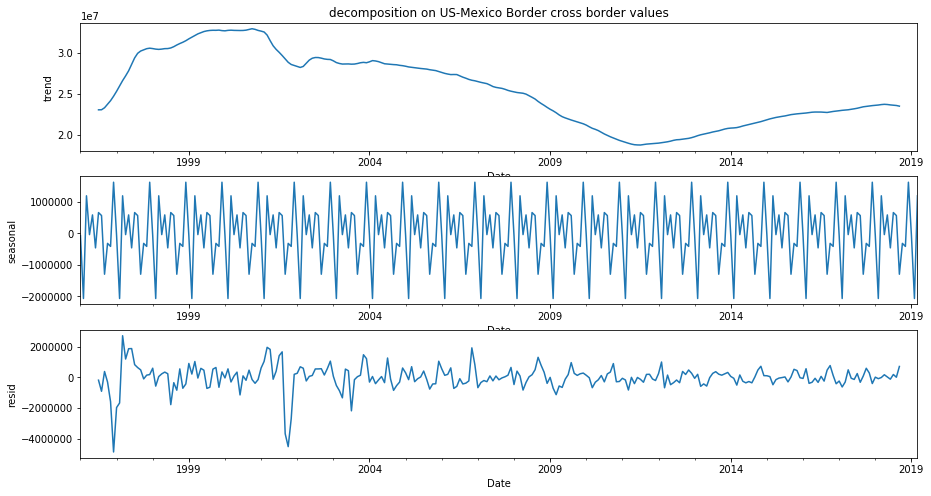

In [6]:
decompose_df(data_trucks, 'Trucks')

data_us_mx = agg_monthly_value(df_us_mx)
decompose_df(data_us_mx, 'US-Mexico Border')

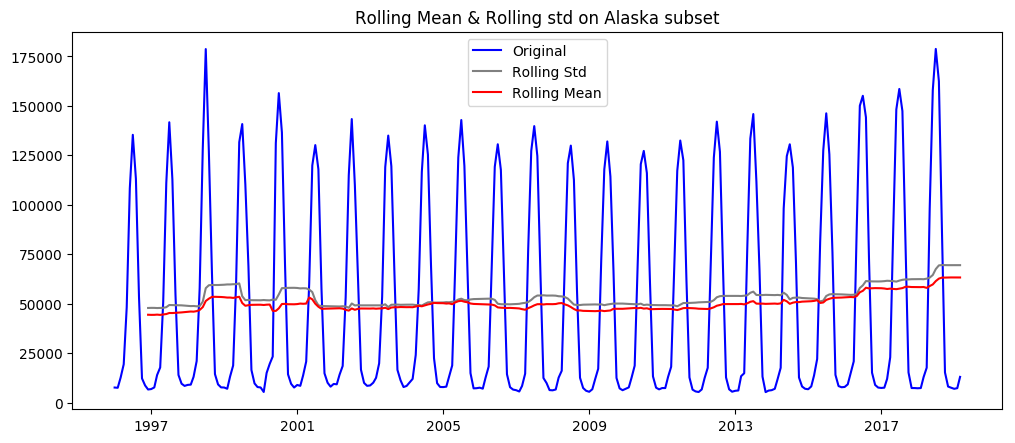

In [16]:
def plot_rolling_mean_std(df, title=None):
    data = agg_monthly_value(df)
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()
    
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(data, color='blue', label='Original')
    plt.plot(rolling_std, color ='grey', label='Rolling Std')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt_title = 'Rolling Mean & Rolling std'
    if title is not None:
        plt_title += " on {} subset".format(title)
    plt.title(plt_title)
    plt.show()
plot_rolling_mean_std(df_alaska, title="Alaska")

In [3]:
def adfuller_test(df):
    print "Use Augmented Dickey-Fuller Test to see if time seies is stationary"
    adf_result = adfuller(df['Value'])
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
adfuller_test(df_alaska)
print "p-value is less than 0.05, thus the time series is stationary"

Use Augmented Dickey-Fuller Test to see if time seies is stationary
ADF Statistic: -7.952436
p-value: 0.000000
p-value is less than 0.05, thus the time series is stationary


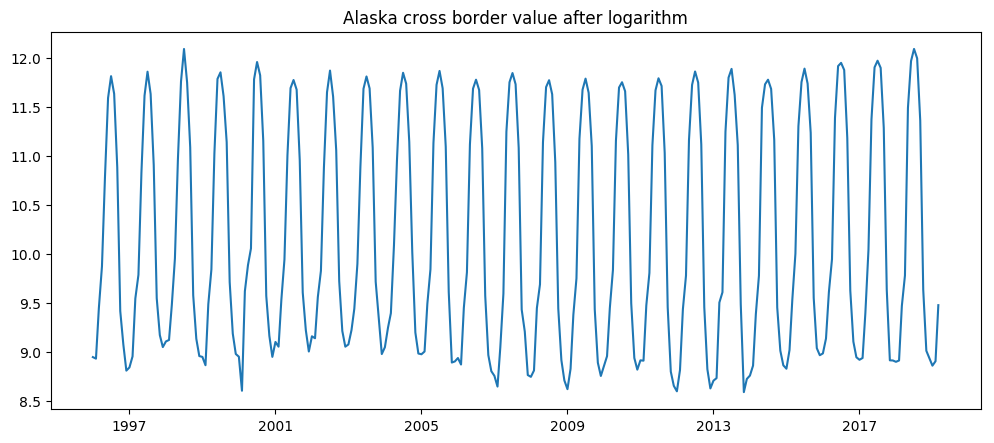

In [6]:
df_log = log_df(df_alaska)
plt.figure(figsize=(12, 5), dpi=100)
plt.title('Alaska cross border value after logarithm')
plt.plot(df_log)

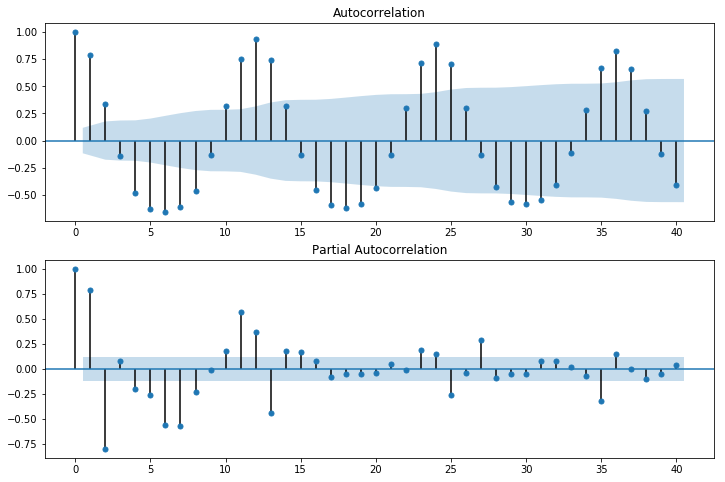

In [7]:
def plot_acf_pacf(df):
    data = agg_monthly_value(df)

    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1) # 
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2)# , lags=40
plot_acf_pacf(df_alaska)
#print "set p to 1 and q to 1"

determining p, d, q and P, D, Q

In [6]:
data_alaska = agg_monthly_value(df_alaska)
resDiff = sm.tsa.arma_order_select_ic(data_alaska.values, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =', resDiff['aic_min_order'],'is the best.')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-package

('ARMA(p,q) =', (6, 7), 'is the best.')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [4]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
def grid_search_SARIMAX(df_input, val_range=(0, 2)):
    P = D = Q = range(val_range[0], val_range[1])
    PDQ = list(itertools.product(P, D, Q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in PDQ]
    df_input_log = log_df(df_input)
    index_p85_input = int(len(df_input_log.index) * 0.85)
    train_input = df_input_log[:index_p85_input]
    test_input = df_input_log[index_p85_input:]
    params_best, param_seasonal_best, AIC_best = None, None, float("inf")
    best_AIC = float("inf")
    for param in PDQ:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_input, order=param, seasonal_order=param_seasonal,
                                                enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()
                if best_AIC > results.aic:
                    params_best, param_seasonal_best, best_AIC = param, param_seasonal, results.aic
                    print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                
            except Exception as ex:
                print ex.message
                continue
    print "best hyperparameters by grid search: ARIMA{}, Seasonal{}".format(params_best, param_seasonal_best)
    
grid_search_SARIMAX(df_alaska)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1770.06835072
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1684.34679879
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-193.09336165
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-230.230904404
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-243.242953691
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-249.449278562
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-256.309688297
best hyperparameters by grid search: ARIMA(1, 0, 0), Seasonal(1, 0, 1, 12)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  237
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 107.028
Date:                            Sun, 15 Dec 2019   AIC                           -204.056
Time:                                    20:48:28   BIC                           -186.715
Sample:                                01-01-1996   HQIC                          -197.066
                                     - 09-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9966      0.005    195.886      0.000       0.987       1.007
ma.L1         -0.8965      0.026   

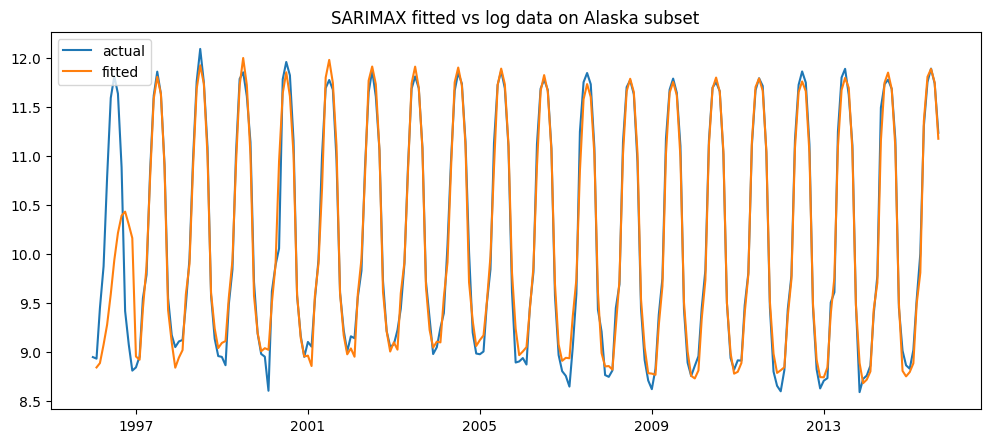

In [9]:
def train_SARIMAX(df, order, seasonal_order, title=None):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    df_log = log_df(df)
    index_p85 = int(len(df_log.index) * 0.85)
    train = df_log[:index_p85]
    test = df_log[index_p85:]
    model = SARIMAX(train, trend='n', order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=-1)
    print model_fit.summary()
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(train, label='actual')
    plt.plot(model_fit.fittedvalues[1:], label='fitted')
    plt_title = "SARIMAX fitted vs logarithm data"
    if title is not None:
        plt_title = "SARIMAX fitted vs log data on {} subset".format(title)
    plt.title(plt_title)
    plt.legend(loc="upper left")
    return model_fit

model_fit = train_SARIMAX(df_alaska, (1, 0, 1), (1,0,1,12), title="Alaska")

SARIMAX model diagnostics. It's a very good fit!

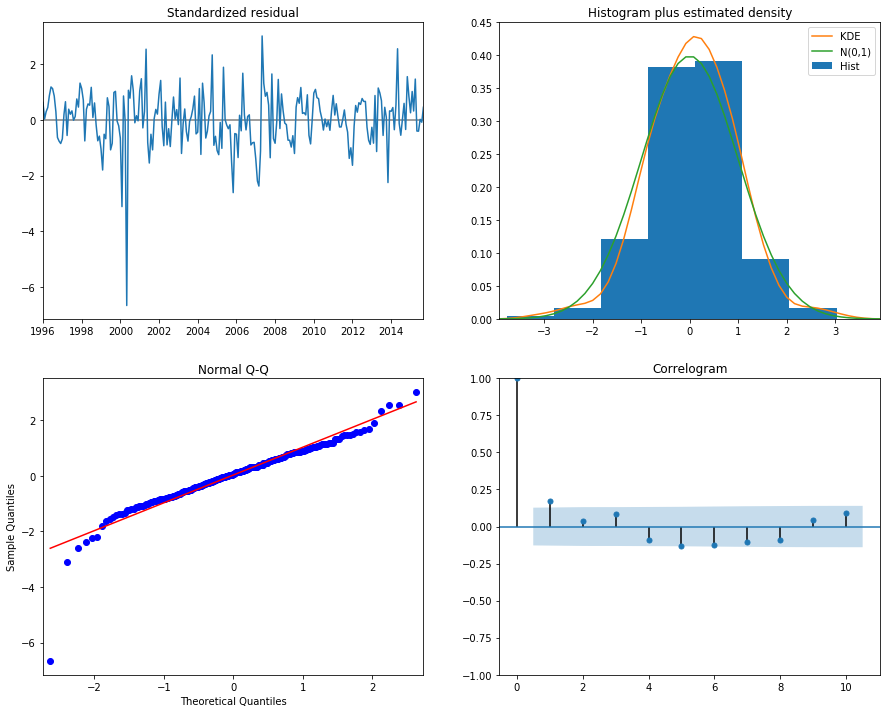

In [20]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


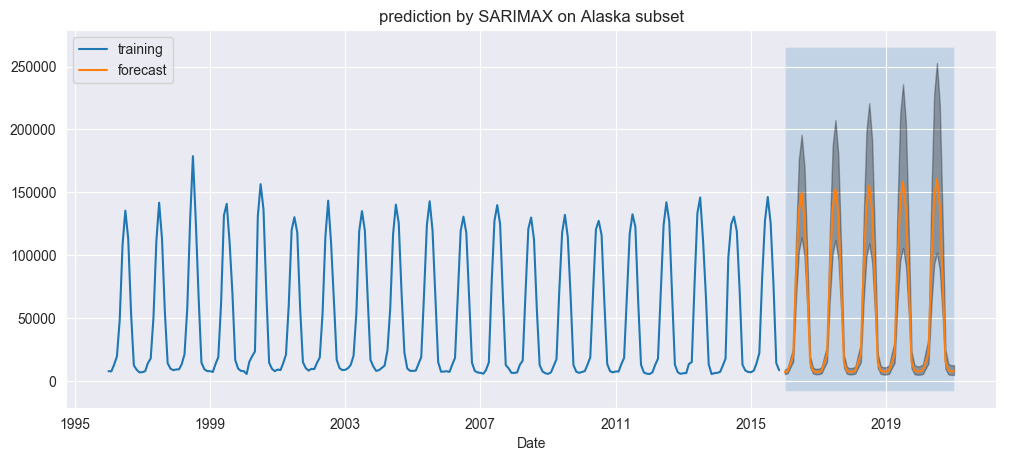

In [10]:
def SARIMAX_predict(model, df, title=None, start=240, end=300):
    data = agg_monthly_value(df)
    #df_log = log_df(df)
    forecast_log = model.predict(start=start, end=end, dynamic=True)
    forecast = np.exp(forecast_log)
    index_p85 = int(len(data.index) * 0.85)
    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 5), dpi=100)
    
    predict = model.get_prediction(start=start, end=end, dynamic=False)
    pred_ci = predict.conf_int()
    
    ax = sns.lineplot(x=data[:index_p85 + 2].index, y=data[:index_p85 + 2].values, label='training')
    ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.3)
    ax.fill_betweenx(ax.get_ylim(), pred_ci.index[0], pred_ci.index[-1],
                 alpha=.2, zorder=-1)
    sns.lineplot(x=forecast.index, y=forecast.values, label='forecast')
    plt_title = "prediction by SARIMAX"
    if title is not None:
        plt_title = "prediction by SARIMAX on {} subset".format(title)
    plt.title(plt_title)
    plt.legend(loc='upper left')
SARIMAX_predict(model_fit, df_alaska, "Alaska")

Alaska subset storytelling

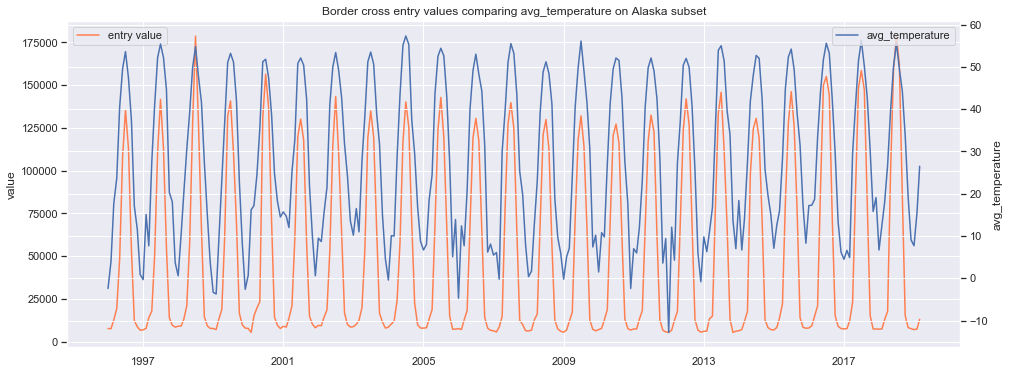

In [23]:
def plot_feature_comparison(df_input, feature_to_compare, title, agg_method='avg'):
    data_input = agg_monthly_value(df_input)
    feature2_input = agg_monthly_value(df_input, col=feature_to_compare, agg_method=agg_method)
    if feature_to_compare == 'GDP':
        feature2_input = feature2_input.loc[feature2_input.index >= '2005-12-31 08:00:00']
    sns.set()
    plt.figure(figsize=(16, 6))
    ax = sns.lineplot(x=data_input.index, y=data_input.values, color="coral", label='entry value')
    ax2 = plt.twinx()
    ax.set_ylabel('value', fontsize='medium')
    ax2.set_ylabel(feature_to_compare, fontsize='medium')
    sns.lineplot(x=feature2_input.index, y=feature2_input.values, ax=ax2, label=feature_to_compare)
    plt.legend(loc="upper right")
    plt.title("Border cross entry values comparing {} on {} subset".format(feature_to_compare, title))
    ax.xaxis.label.set_visible(False)

plot_feature_comparison(df_alaska, 'avg_temperature', "Alaska")

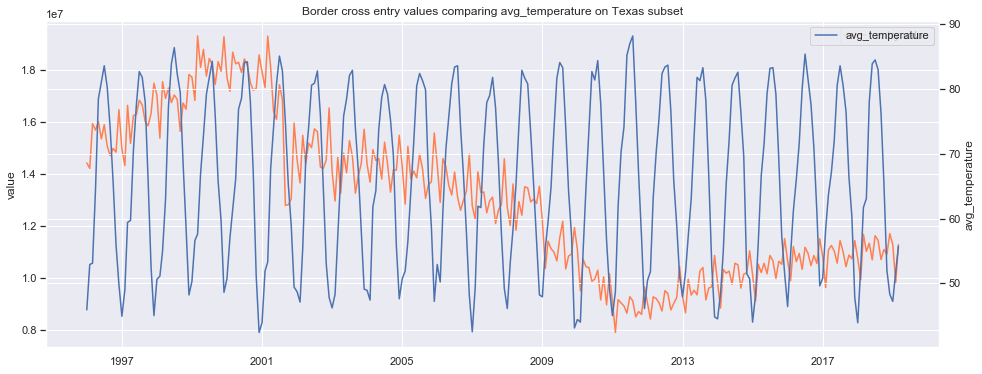

In [25]:
plot_feature_comparison(df_texas, 'avg_temperature', "Texas")

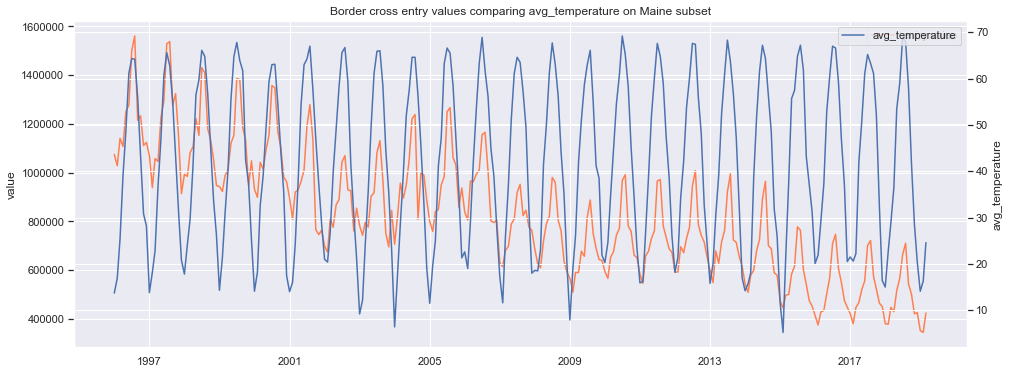

In [26]:
df_maine = get_subset('Maine')
plot_feature_comparison(df_maine, 'avg_temperature', "Maine")

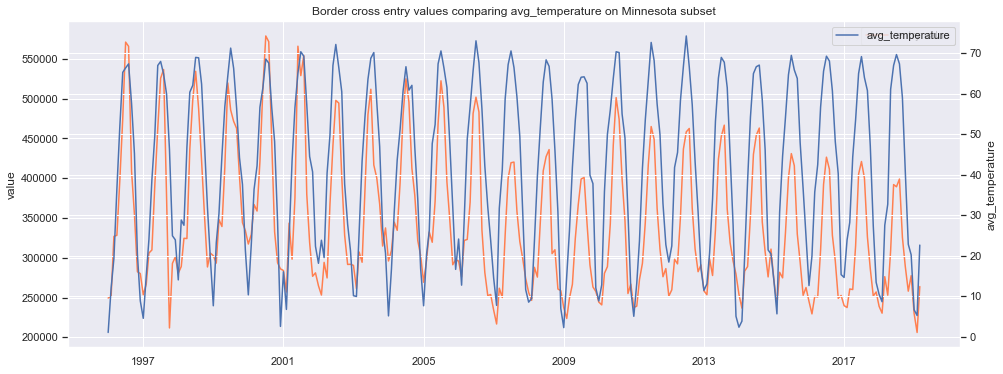

In [27]:
df_Minnesota = get_subset('Minnesota')
plot_feature_comparison(df_Minnesota, 'avg_temperature', "Minnesota")

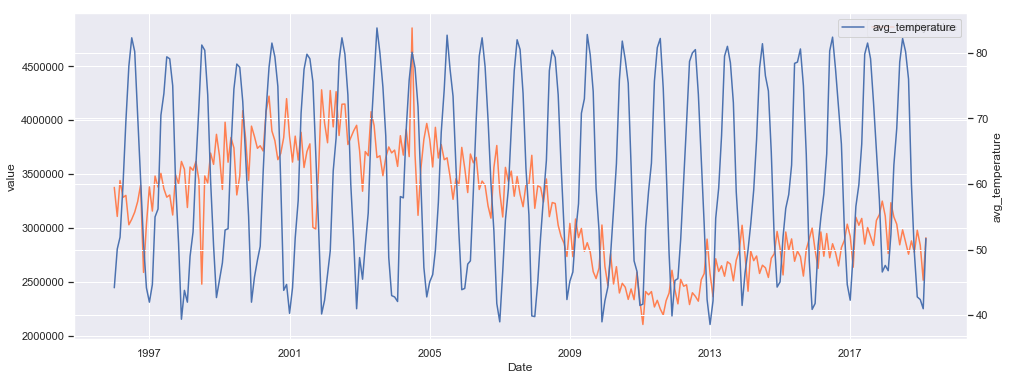

In [81]:
df_maine = get_subset('Arizona')
plot_feature_comparison(df_maine, 'avg_temperature')

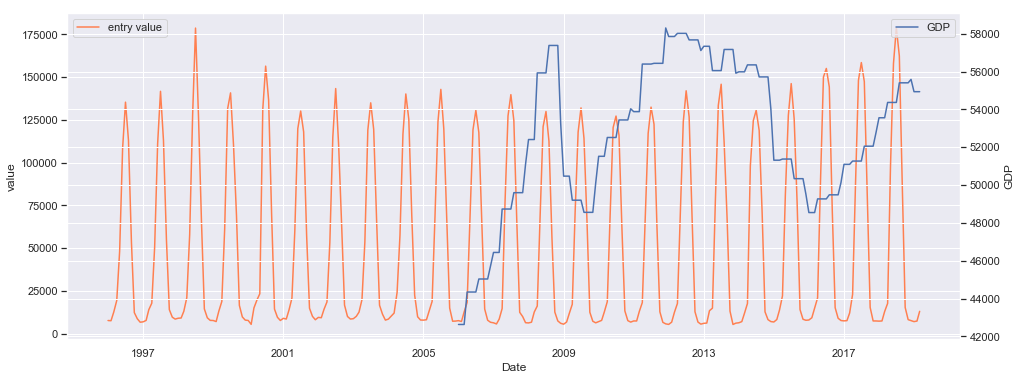

In [82]:
plot_feature_comparison(df_alaska, 'GDP')

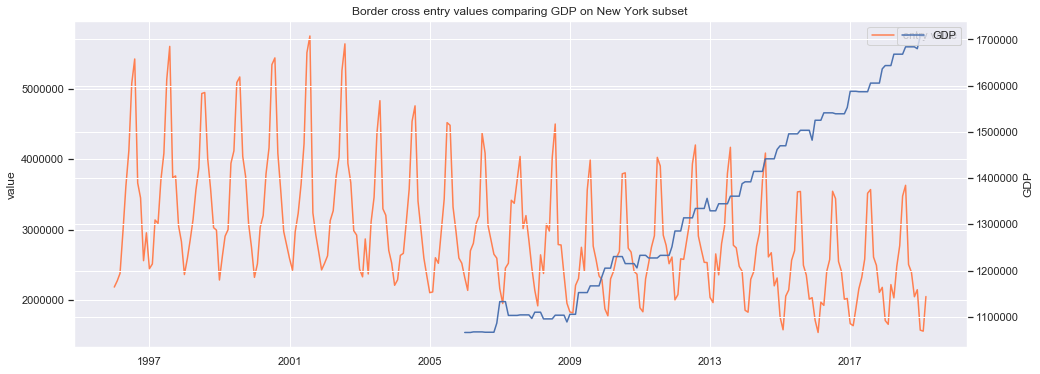

In [29]:
df_NY = get_subset('New York')
plot_feature_comparison(df_NY, 'GDP', "New York")

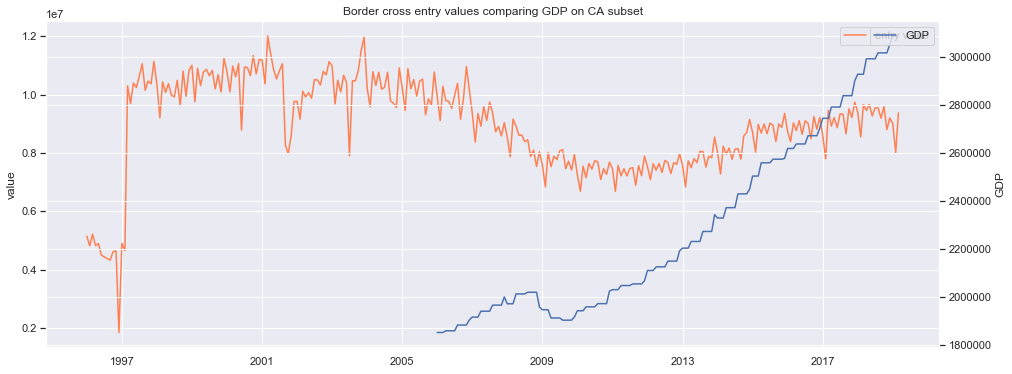

In [30]:
plot_feature_comparison(df_CA, 'GDP', "CA")

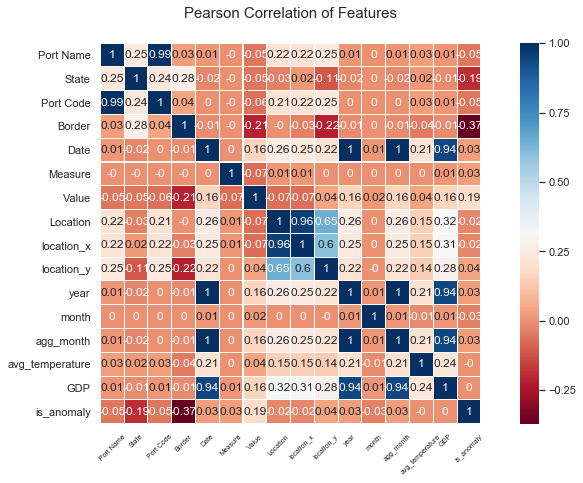

In [85]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 7))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1).round(decimals=2),
            linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.xticks(rotation=45, fontsize=7)

plt.show()

deep dive cross border values of Texas


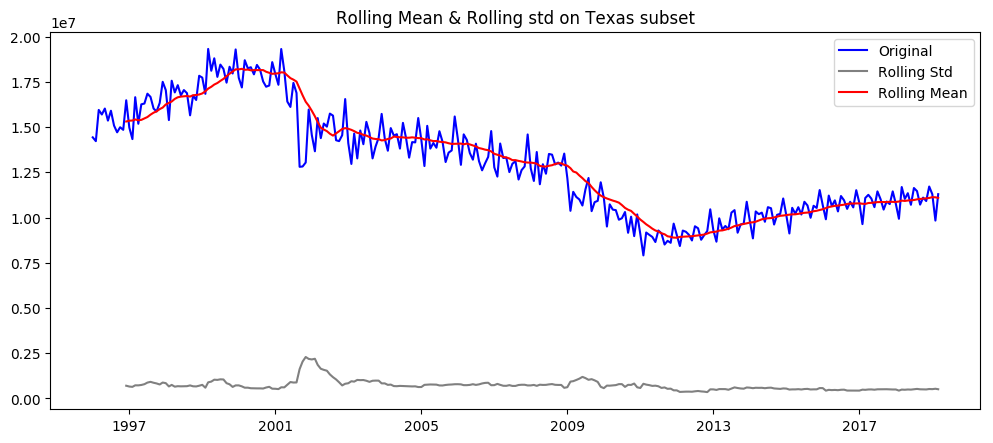

In [18]:
print "deep dive cross border values of Texas"
df_texas = df[(df['State'] == 'Texas')]
plot_rolling_mean_std(df_texas, "Texas")

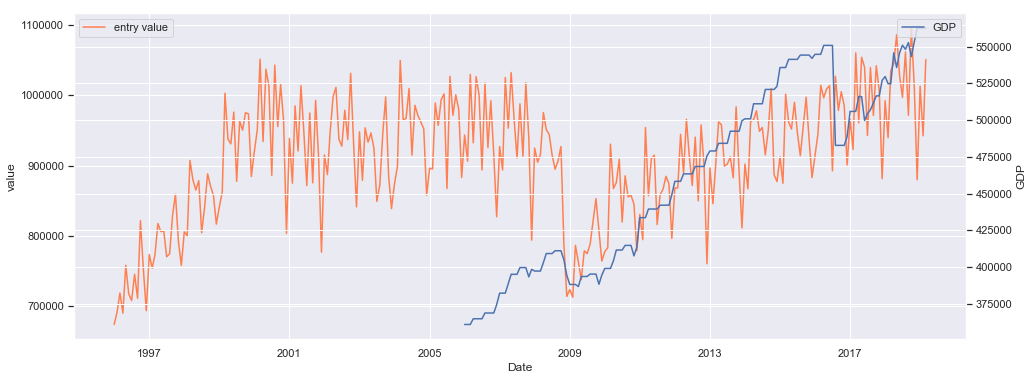

In [65]:
plot_feature_comparison(df_trucks, 'GDP')

In [120]:
adfuller_test(df_texas)

Use Augmented Dickey-Fuller Test to see if time seies is stationary
ADF Statistic: -191.732437
p-value: 0.000000


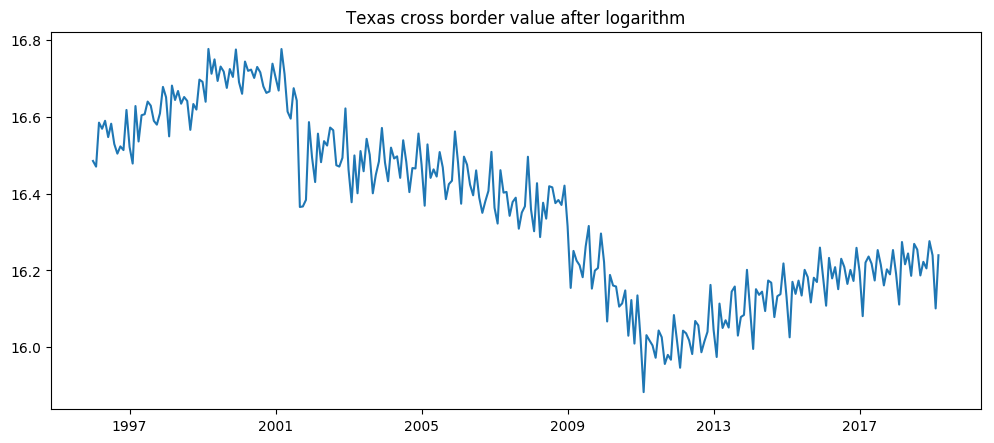

In [130]:
df_log_texas = log_df(df_texas)
plt.figure(figsize=(12, 5), dpi=100)
plt.title('Texas cross border value after logarithm')
plt.plot(df_log_texas)

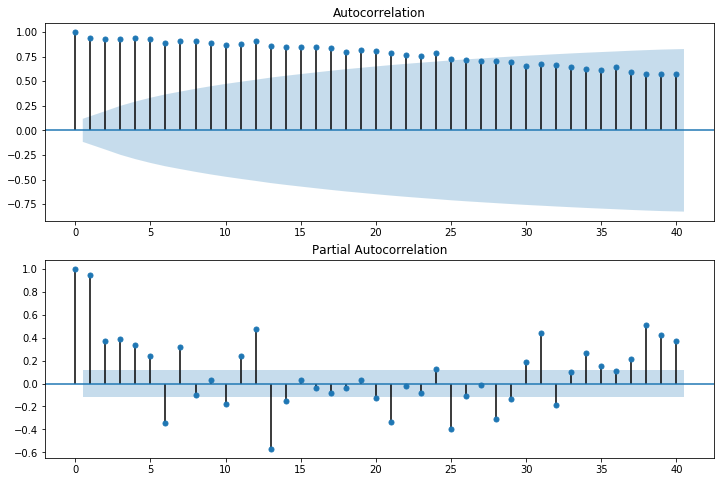

In [8]:
plot_acf_pacf(df_texas)

In [6]:
grid_search_SARIMAX(df_texas, val_range=(0, 3))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1991.64464603
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1894.18758896
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1548.34657314
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-462.157613248
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-477.341237029
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-478.775674659
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-596.419055092
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-610.718565058
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:-655.872868736
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:-663.171095679
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-723.488604955
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-778.102720724
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-816.837007931
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-825.155775329
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-825.263540745
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-830.214208419
best hyperparameters by grid search: ARIMA(1, 0, 1), Seasonal(1, 0, 1, 12)


                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  237
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 430.294
Date:                            Fri, 13 Dec 2019   AIC                           -850.588
Time:                                    16:16:38   BIC                           -833.248
Sample:                                01-01-1996   HQIC                          -843.599
                                     - 09-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   5044.554      0.000       0.999       1.000
ma.L1         -0.2911      0.027   

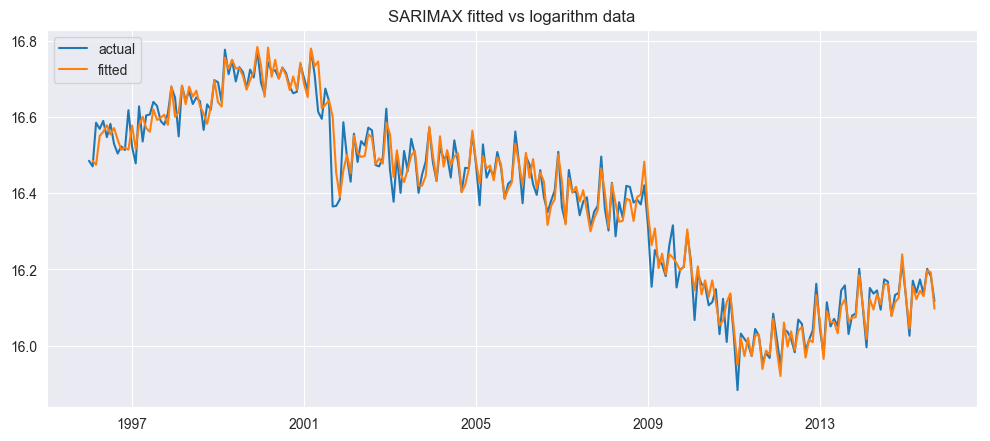

In [13]:
model_texas = train_SARIMAX(df_texas, (1, 0, 1), (1,0,1,12))

prediction by SARIMAX on Texas border cross entry value


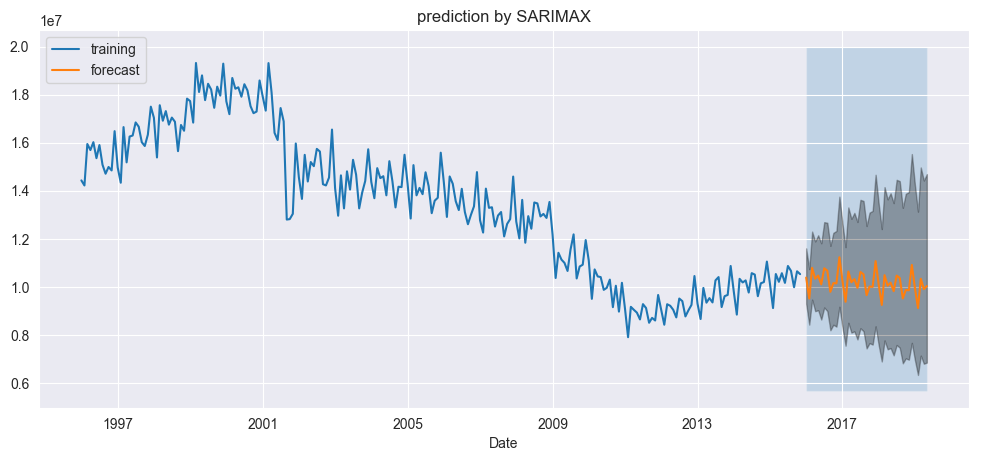

In [14]:
print "prediction by SARIMAX on Texas border cross entry value"
SARIMAX_predict(model_texas, df_texas, start=240, end=280)

deep dive US-Canada Border cross entry data


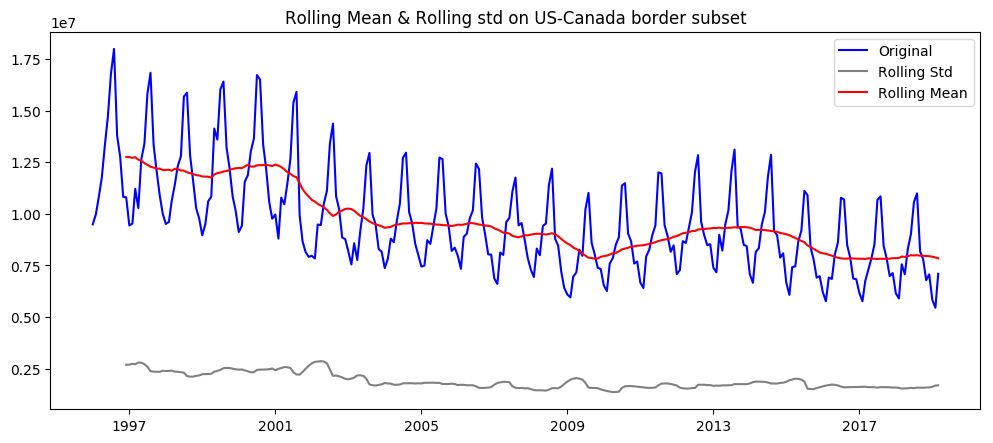

In [19]:
print "deep dive US-Canada Border cross entry data"
df_us_ca = df[(df['Border'] == "US-Canada Border")]
plot_rolling_mean_std(df_us_ca, "US-Canada border")

In [12]:
adfuller_test(df_us_ca)

Use Augmented Dickey-Fuller Test to see if time seies is stationary
ADF Statistic: -101.263872
p-value: 0.000000


/Users/yelin/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


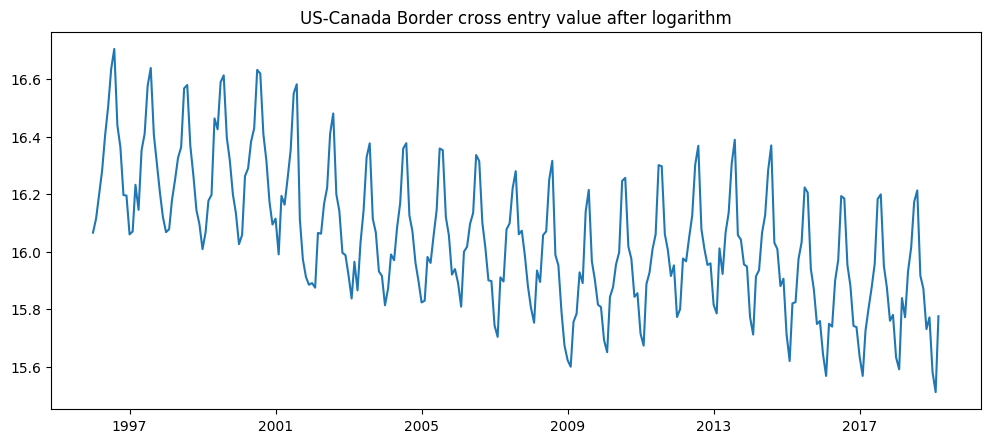

In [13]:
df_log_us_ca = log_df(df_us_ca)
plt.figure(figsize=(12, 5), dpi=100)
plt.title('US-Canada Border cross entry value after logarithm')
plt.plot(df_log_us_ca)

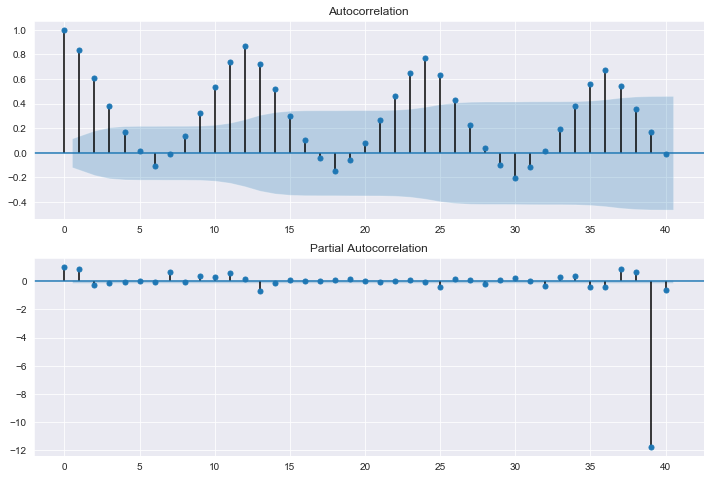

In [15]:
plot_acf_pacf(df_us_ca)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  237
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 372.712
Date:                            Sun, 15 Dec 2019   AIC                           -735.424
Time:                                    20:49:08   BIC                           -718.084
Sample:                                01-01-1996   HQIC                          -728.435
                                     - 09-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   6006.439      0.000       1.000       1.000
ma.L1         -0.3868      0.024   

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


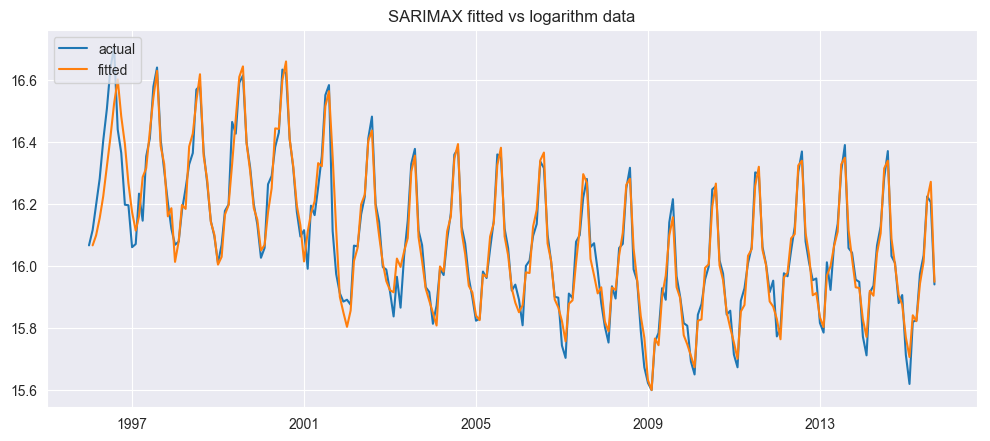

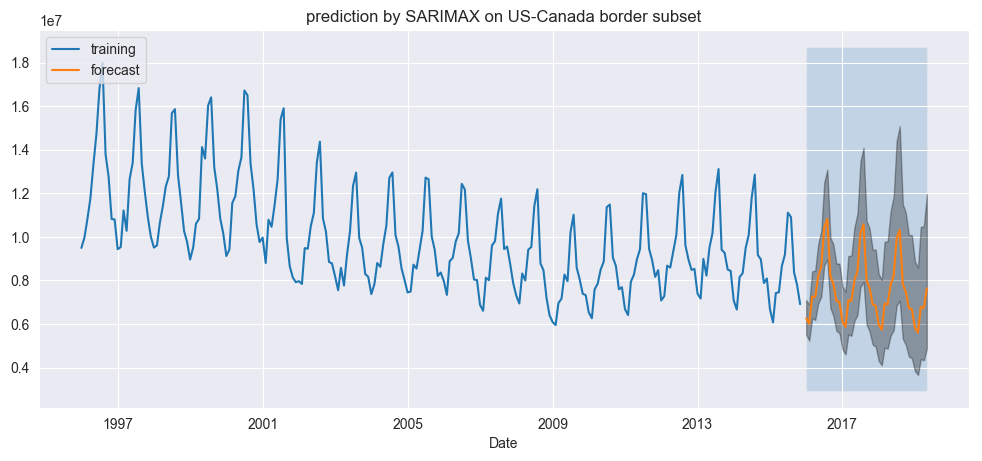

In [12]:
model_us_ca = train_SARIMAX(df_us_ca, (1, 0, 1), (1, 0, 1, 12))
print "prediction by SARIMAX on US Canada border cross entry value"
SARIMAX_predict(model_us_ca, df_us_ca, title="US-Canada border", start=240, end=280)